## Load Data

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.formula.api as smf
from sqlalchemy import create_engine
import seaborn as sns

# Display preferences
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action='ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

temperature_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# No need for an open connection, as we're only doing a single query
engine.dispose()

temperature_df.head(10)

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472,7.389,0.890,14.120,251.000,15.826,0.000,1015.130,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.356,7.228,0.860,14.265,259.000,15.826,0.000,1015.630,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.378,9.378,0.890,3.928,204.000,14.957,0.000,1015.940,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.289,5.944,0.830,14.104,269.000,15.826,0.000,1016.410,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.756,6.978,0.830,11.045,259.000,15.826,0.000,1016.510,Partly cloudy throughout the day.
5,2006-04-01 03:00:00+00:00,Partly Cloudy,rain,9.222,7.111,0.850,13.959,258.000,14.957,0.000,1016.660,Partly cloudy throughout the day.
6,2006-04-01 04:00:00+00:00,Partly Cloudy,rain,7.733,5.522,0.950,12.365,259.000,9.982,0.000,1016.720,Partly cloudy throughout the day.
7,2006-04-01 05:00:00+00:00,Partly Cloudy,rain,8.772,6.528,0.890,14.152,260.000,9.982,0.000,1016.840,Partly cloudy throughout the day.
8,2006-04-01 06:00:00+00:00,Partly Cloudy,rain,10.822,10.822,0.820,11.318,259.000,9.982,0.000,1017.370,Partly cloudy throughout the day.
9,2006-04-01 07:00:00+00:00,Partly Cloudy,rain,13.772,13.772,0.720,12.526,279.000,9.982,0.000,1017.220,Partly cloudy throughout the day.


## Build Model

Build a regression model where the target variable is temperature. As explanatory variables, use humidity, windspeed, windbearing, and pressure. Estimate the model using OLS.

In [2]:
# Y is the target variable
Y = temperature_df['temperature']

# X is the feature set which includes
# humidity, windspeed, windbearing, and pressure
X = temperature_df[['humidity', 'windspeed',
                    'windbearing', 'pressure']]

# Create a LinearRegression model object
# from scikit-learn's linear_model module
lrm = linear_model.LinearRegression()

# Use fit method to estimate the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]

Intercept: 
 37.92643818528537


## Check Gauss-Markov Conditions

### Assumption 1: Linearity of the model in its coefficients

Condition met. Model used takes into account this assumption.

### Assumption 2: Error term should be zero on average

In [5]:
predictions = lrm.predict(X)
errors = Y - predictions


print("Mean of the errors in the temperature model is: {}".format(np.mean(errors)))

Mean of the errors in the temperature model is: -1.9624955657832385e-15


Condition met. Constant term included in model. Average of the model's errors is essentially zero.

### Assumption 3: Homoscedasticity

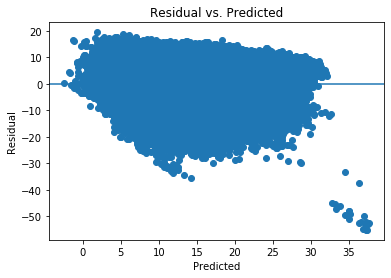

In [6]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [8]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print('Bartlett test statistic value is {0:2g} and p value is {1:3g}'.format(bart_stats[0], bart_stats[1]))
print('\nLevene test statistic value is {0:3g} and p value is {1:.3g}'.format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is   0

Levene test statistic value is 2321.24 and p value is 0


Condition not met. The model poorly predicts higher temperatures. The p-values for both tests are less than 0.05, suggesting that the errors are heteroscedastic rather than homoscedastic.

The estimated coefficients are still valid, but downstream t-tests may be unreliable.

### Assumption 4: Low multicollinearity

In [14]:
# Look at correlation matrix for features
temperature_df.corr()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
temperature,1.000,0.993,-0.632,0.009,0.030,0.393,nan,-0.005
apparenttemperature,0.993,1.000,-0.603,-0.057,0.029,0.382,nan,-0.000
humidity,-0.632,-0.603,1.000,-0.225,0.001,-0.369,nan,0.005
windspeed,0.009,-0.057,-0.225,1.000,0.104,0.101,nan,-0.049
windbearing,0.030,0.029,0.001,0.104,1.000,0.048,nan,-0.012
visibility,0.393,0.382,-0.369,0.101,0.048,1.000,nan,0.060
loudcover,nan,nan,nan,nan,nan,nan,nan,nan
pressure,-0.005,-0.000,0.005,-0.049,-0.012,0.060,nan,1.000


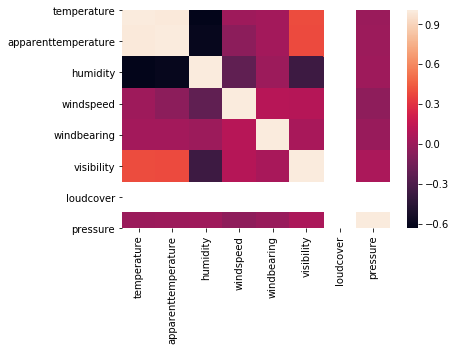

In [15]:
sns.heatmap(temperature_df.corr())
plt.show()

    Humidity and windspeed (-0.225)
    Humidity and windbearing (0.001)
    Humidity and pressure (0.005)
    Windspeed and windbearing (0.104)
    Windspeed and pressure (0.049)
    Windbearing and pressure (0.012)

Condition met. Individual features are only weakly correlated with each other.

### Assumption 5: Error terms should be uncorrelated with one another

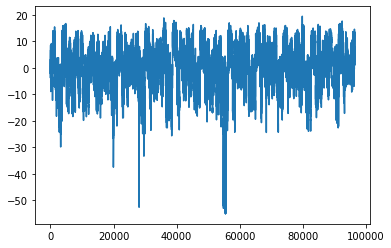

In [16]:
plt.plot(errors)
plt.show()

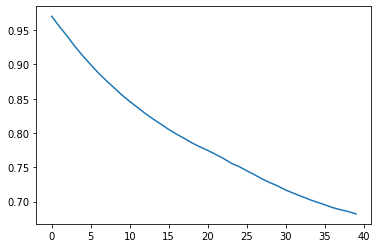

In [17]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

Condition not met. Do not observe randomness in the visualization. Autocorrelation between the errors of our temperature model is quite high, ranging from 0.7 to beyond 0.95.

This suggests that the error term for one observation can at least partially predict the error term for another. Perhaps this means an important/relevant variable is missing from our model.

### Assumption 6: Features shouldn't be correlated with the errors

In [19]:
temperature_df['errors'] = errors

In [21]:
temperature_df.corr()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,errors
temperature,1.000,0.993,-0.632,0.009,0.030,0.393,nan,-0.005,0.761
apparenttemperature,0.993,1.000,-0.603,-0.057,0.029,0.382,nan,-0.000,0.765
humidity,-0.632,-0.603,1.000,-0.225,0.001,-0.369,nan,0.005,-0.000
windspeed,0.009,-0.057,-0.225,1.000,0.104,0.101,nan,-0.049,0.000
windbearing,0.030,0.029,0.001,0.104,1.000,0.048,nan,-0.012,0.000
visibility,0.393,0.382,-0.369,0.101,0.048,1.000,nan,0.060,0.211
loudcover,nan,nan,nan,nan,nan,nan,nan,nan,nan
pressure,-0.005,-0.000,0.005,-0.049,-0.012,0.060,nan,1.000,-0.000
errors,0.761,0.765,-0.000,0.000,0.000,0.211,nan,-0.000,1.000


Condition met. Features are not correlated with the errors.

### Normality of the Errors

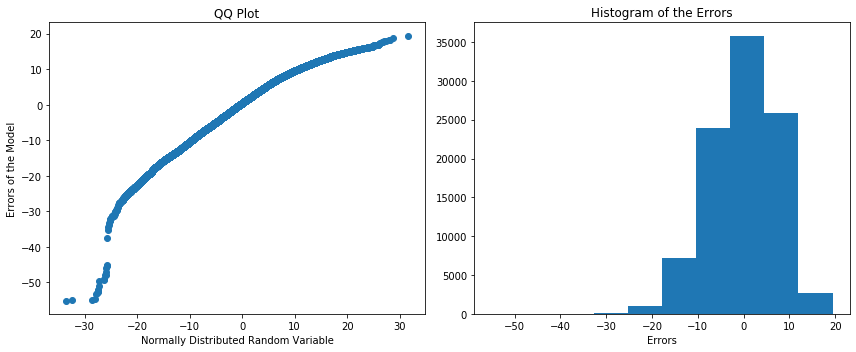

In [22]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("Normally Distributed Random Variable")
plt.ylabel("Errors of the Model")
plt.title("QQ Plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("Errors")
plt.title("Histogram of the Errors")

plt.tight_layout()
plt.show()

In [23]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3793.296735252356 and p value is 0.0
Normality test statistics is 3375.4323076995797 and p value is 0.0


Errors are not normally distributed.